# 1.4 Transforming Variables

In this section, we will transform and combine existing variables to obtain new variables. Our examples are drawn from a data set of house prices in Ames, Iowa.  This data set is stored in a tab-separated values file.  For more information about the variables in this data set, please refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [ ]:
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 10

df = pd.read_csv("AmesHousing.txt",sep="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Applying Transformations

### Quantitative Variables

There are several reasons to transform quantitative variables, including:

1. to change the measurement units
2. to make the variable more amenable to analysis

As an example of the first reason, suppose we want the lot areas to be in acres instead of square feet. Since there are 43560 square feet in an acre, this requires dividing each lot area by 43560. We can **broadcast** the division over the entire `Series`.

In [ ]:
df["Lot Area"] / 43560

0       0.729339
1       0.266804
2       0.327525
3       0.256198
4       0.317493
          ...   
2925    0.182208
2926    0.203972
2927    0.239692
2928    0.229798
2929    0.221006
Name: Lot Area, Length: 2930, dtype: float64

If we want to store the results as a new variable in the `DataFrame`, we simply assign the `Series` to a new column in the `DataFrame`. The command below does two things: creates a new column in the `DataFrame` called "Lot Area (acres)" _and_ populates it with the values from the `Series` above.

In [ ]:
df["Lot Area (acres)"] = df["Lot Area"] / 43560

The second reason for transforming quantitative variables is to make them more amenable to analysis. To see why a variable might not be amenable to analysis, let's take a look at a histogram of lot areas.

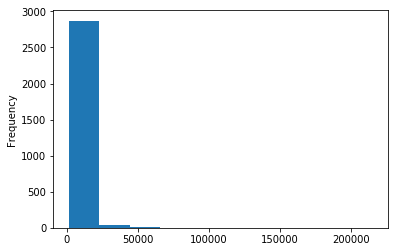

In [ ]:
df["Lot Area"].plot.hist()

There are a few homes with such extreme lot areas that we get virtually no resolution at the lower end of the distribution. Over 95% of the observations are in a single bin of this histogram. In other words, this variable is extremely **skewed**.

One way to improve this histogram is to use more bins. But this does not solve the fundamental problem: we need more resolution at the lower end of the scale and less resolution at the higher end. One way to spread out the values at the lower end of a distribution and to compress the values at the higher end is to take the logarithm (provided that the values are all positive). Log transformations are particularly effective at dealing with right-skewed data.

The log function is not built into Python or `pandas`. We have to import the log function from a library called `numpy`, which contains many functions and data structures for numerical computations. In fact, `pandas` is built on top of `numpy`. When we apply `numpy`'s `log` function to a `pandas` `Series`, the function is automatically broadcast over the elements of the `Series`, returning another `Series`. Let's save the results to a variable called "log(Lot Area)".

In [ ]:
import numpy as np
df["log(Lot Area)"] = np.log(df["Lot Area"])
df["log(Lot Area)"]

0       10.366278
1        9.360655
2        9.565704
3        9.320091
4        9.534595
          ...    
2925     8.979291
2926     9.092120
2927     9.253496
2928     9.211340
2929     9.172327
Name: log(Lot Area), Length: 2930, dtype: float64

These numbers are not very interpretable on their own, but if we make a histogram of these values, we see that the lower end of the distribution is now more spread out, and the extreme values are not so extreme anymore.

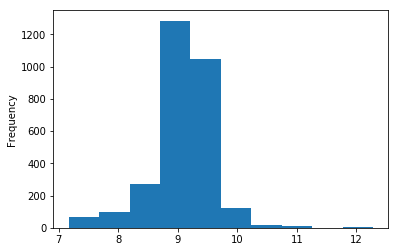

In [ ]:
df["log(Lot Area)"].plot.hist()

It is possible for a log transformation to overcorrect for skew. For example, the "SalePrice" variable is also right-skewed.

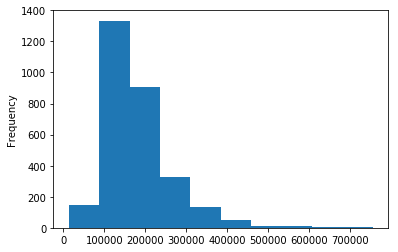

In [ ]:
df["SalePrice"].plot.hist()

But if we take logs, the distribution becomes somewhat left-skewed.

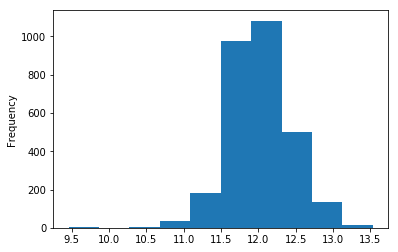

In [ ]:
np.log(df["SalePrice"]).plot.hist()

Is there a transformation that makes the resulting distribution more symmetric?

In fact, log is just one transformation in a whole family of transformations. Because the transformations in this family involve raising the values to some power, the statistician John Tukey called this the **ladder of powers**:

$$ x(\lambda) = \begin{cases} x^\lambda & \lambda > 0 \\  \log(x) & \lambda = 0 \\ -x^\lambda & \lambda < 0 \end{cases} $$

$\lambda = 1$ corresponds to no transformation at all. As we decrease $\lambda$, the distribution becomes more left-skewed (which is useful if the original distribution was right-skewed). Since log ($\lambda = 0$) was an overcorrection, let's back off and increase $\lambda$:

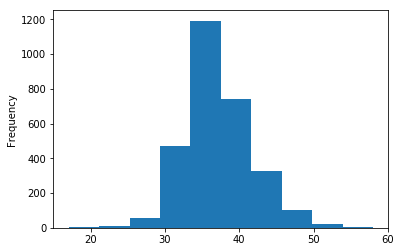

In [ ]:
(df["SalePrice"] ** .3).plot.hist()

This seems to be better. We can move $\lambda$ up and down the ladder until the distribution is the shape we want.

### Why $\lambda = 0$ corresponds to $\log$ (Optional)

You might have noticed that it does not make sense to use the transformation $x^0$ for $\lambda = 0$, since anything raised to the zero power equals 1. But why is $\log(x)$ the right function to replace $x^0$?

The answer has to do with calculus. We want to understand the behavior of $x^\lambda$ as $\lambda$ approaches 0. To do this properly, we actually need to consider the function

$$\frac{x^\lambda - 1}{\lambda}.$$

Subtracting 1 and dividing by $\lambda$ are just constants that shift and scale the distribution; they do not affect the overall shape of the distribution. Therefore, the histogram of $x^\lambda$ will look the same as the histogram of $(x^\lambda - 1) / \lambda$; only the axes will be different.

Using calculus, you can show that the limit of the above function as $\lambda$ approaches 0 is:

$$\lim_{\lambda \to 0} \frac{x^\lambda - 1}{\lambda} = \log(x).$$

(Challenge: prove this!) This is why it makes sense to slot $\log(x)$ in for $x^0$.

### Other Mathematical Functions in Numpy (Optional)

You might wonder what other mathematical functions are available in `numpy` besides `log`. For one, there is `log10`, which implements the base-10 logarithm. (By default, `np.log` is the natural logarithm, base-$e$.) 

[Here is an exhaustive list of the mathematical functions](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.math.html). All of these functions are compatible with `pandas`.

### Categorical Variables

Categorical variables sometimes also require transformation, although for different reasons than quantitative variables. With categorical variables, the values are usually labels, so it does not make sense to take logarithms or to raise them to powers. However, we might want to change the labels of the categories.

For example, according to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt), the categorical variable "Heating QC" (heating quality and condition) in the Ames data set has five categories: excellent, good, average/typical, fair, and poor.

In [ ]:
df["Heating QC"]

0       Fa
1       TA
2       TA
3       Ex
4       Gd
        ..
2925    TA
2926    TA
2927    TA
2928    Gd
2929    Ex
Name: Heating QC, Length: 2930, dtype: object

The categories are currently labeled as "Ex", "Gd", "TA", "Fa", and "Po", which might be cryptic to a reader. We might want to replace them with more descriptive labels. This requires a transformation.

To do this, we can use the `.map()` method of `Series`. This method takes as input a dictionary that specifies the mapping between the current labels and the desired labels. So, for example, if we want all instances of "Ex" to be replaced by "Excellent", we would add the key "Ex" to this dictionary, with a value of "Excellent".

In [ ]:
df["Heating QC"].map({
    "Ex": "Excellent",
    "Gd": "Good",
    "TA": "Average",
    "Fa": "Fair",
    "Po": "Poor"
})

0            Fair
1         Average
2         Average
3       Excellent
4            Good
          ...    
2925      Average
2926      Average
2927      Average
2928         Good
2929    Excellent
Name: Heating QC, Length: 2930, dtype: object

Now when we make a bar chart, the labels will come out correctly. We just have to make sure they come out in the order we want.

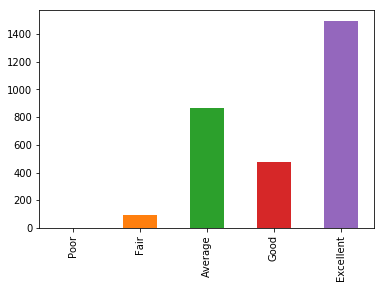

In [ ]:
df["Heating QC"].map({
       "Ex": "Excellent",
       "Gd": "Good",
       "TA": "Average",
       "Fa": "Fair",
       "Po": "Poor"
}).value_counts()[["Poor", "Fair", "Average", "Good", "Excellent"]].plot.bar()

Transformations of categorical variables are not always merely cosmetic. For example, we may want to combine several categories into one. The code below turns heating quality into a binary categorical variable (acceptable / unacceptable), according to whether the heating quality is at least average:

In [ ]:
df["Heating QC Binary"] = df["Heating QC"].map({
       "Ex": "Acceptable",
       "Gd": "Acceptable",
       "TA": "Acceptable",
       "Fa": "Unacceptable",
       "Po": "Unacceptable"
})

df["Heating QC Binary"]

0       Unacceptable
1         Acceptable
2         Acceptable
3         Acceptable
4         Acceptable
            ...     
2925      Acceptable
2926      Acceptable
2927      Acceptable
2928      Acceptable
2929      Acceptable
Name: Heating QC Binary, Length: 2930, dtype: object

The binary variable contains less information than the original variable, but we may not need the finer-grained detail about the heating, if all we want to know is whether it is acceptable or not. 

In [ ]:
df["Heating QC Binary"].value_counts()

Acceptable      2835
Unacceptable      95
Name: Heating QC Binary, dtype: int64

## Combining Variables

We can also create new variables out of multiple existing variables. For example, in the current data set, the information about when a house was sold is spread across two variables, "Yr Sold" and "Mo Sold" (1-12 indicating the month). We can combine these two variables into one, by dividing the month the house was sold by 12 and then adding that to the year. So for example, this new variable would equal 2010.5 if the house was sold in June 2010 and 2006.75 if it was sold in September 2006.

In [ ]:
df["Date Sold"] = df["Yr Sold"] + df["Mo Sold"] / 12
df["Date Sold"]

0       2010.416667
1       2010.500000
2       2010.500000
3       2010.333333
4       2010.250000
           ...     
2925    2006.250000
2926    2006.500000
2927    2006.583333
2928    2006.333333
2929    2006.916667
Name: Date Sold, Length: 2930, dtype: float64

Notice how the division by 12 is _broadcast_ over the elements of the `Series`, and the addition of the two `Series` is elementwise.

Another example of a variable that can be derived from two existing variables is the _cost per square foot_, which is a common way to compare prices of different-sized homes. To calculate the cost per square foot of a home, we can simply divide the two `Series`, and the division will be elementwise.

In [ ]:
df["Cost per Sq Ft"] = df["SalePrice"] / df["Gr Liv Area"]
df["Cost per Sq Ft"]

0       129.830918
1       117.187500
2       129.420617
3       115.639810
4       116.574586
           ...    
2925    142.073779
2926    145.232816
2927    136.082474
2928    122.390209
2929     94.000000
Name: Cost per Sq Ft, Length: 2930, dtype: float64

# Exercises

**Exercise 1.** What happens if you leave out a category in the dictionary that you pass to `.map()`?

In [ ]:
# ENTER YOUR CODE HERE

Exercises 2-4 deal with the Ames housing data set from earlier. Refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) if you have any trouble finding or understanding a variable in this data set.

**Exercise 2.** The number of bathrooms is typically reported as a decimal to allow for half bathrooms (i.e., bathrooms without a shower). In this data set, the number of full bathrooms and the number of half bathrooms are separate variables. Create a new variable with the number of bathrooms in each home.

In [ ]:
# ENTER YOUR CODE HERE

**Exercise 3.** Create a categorical variable that indicates whether or not a home has a pool.

In [ ]:
# ENTER YOUR CODE HERE

**Exercise 4.** There are four types of utilities: electricity, gas, water, and sewage. Right now, the combination of utilities in a home is encoded in a single variable called "Utilities". Convert this variable into four boolean variables, each one indicating whether or not a home has a particular utility.

In [ ]:
# ENTER YOUR CODE HERE

Exercises 5-7 deal with the Tips data set (`tips.csv`).

**Exercise 5.** Make a visualization that shows the distribution of the total bills. Transform the variable first so that it is approximately symmetric.

In [ ]:
# ENTER YOUR CODE HERE

**Exercise 6.** Suppose the total bill + tip are divided evenly among the people in each party. Which table paid the most _per person_?

In [ ]:
# ENTER YOUR CODE HERE

**Exercise 7.** Make a visualization that shows how busy the restaurant is by day. Your visualization should display the full name of each day, i.e., "Thursday" instead of "Thur".

In [ ]:
# ENTER YOUR CODE HERE